# Deep Learning Classification of fdom Anomaly Peaks with Resnet
Using k-fold validation

In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from Anomaly_Detection.Deep_Learning.resnet import ResNet1D
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from Anomaly_Detection.Deep_Learning.datasets import fdomDataset, collate_fn_pad, fdomAugOnlyDataset
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from functools import partial


In [2]:
# util functions
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            print(f"reset trainable params of layer = {layer}")
            layer.reset_parameters()


## Hyperparameters
Adjust as needed!

In [3]:
# Hyperparams
WINDOW_SIZE = 15  # the size of each data segment
SEED = 42
BATCH_SIZE = 32

# this is the number of epochs per fold, but because data is already batched,
# when larger than 1, training takes a long time, make sure you have cuda for fast training
EPOCHS = 1

SPLITS = 5


In [4]:
# Paths to data files
fdom_raw_data = (
    "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_raw_data = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = (
    "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)
fdom_labeled = "Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

# augmented files
fdom_raw_augmented = "Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"
turb_augmented_raw_data = "Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"
stage_augmented_data_fn = "Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

fdom_fpt_lookup_path = "Data/augmented_data/fdom/fpt_lookup.csv"
fdom_fsk_lookup_path = "Data/augmented_data/fdom/fsk_lookup.csv"

In [5]:
# get device (cpu or cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Create Dataset
Use the custom dataset class to setup the dataset, classes, and targets

In [6]:
# list of classnames
classes = ["NAP", "FSK", "FPT", "PLP", "PP", "SKP"]

# create label encoder, encode classes into integers
le = preprocessing.LabelEncoder()
targets = le.fit_transform(classes)

# create dataset
# dataset = fdomDataset(
#     le,
#     fdom_raw_data,
#     stage_raw_data,
#     turb_raw_data,
#     fdom_labeled,
#     fdom_raw_augmented,
#     stage_augmented_data_fn,
#     turb_augmented_raw_data,
#     fdom_labeled_augmented,
# )


In [7]:
# this is purely for class balanced TESTING if we want to do that
dataset = fdomAugOnlyDataset(
    le,
    fdom_raw_augmented,
    stage_augmented_data_fn,
    turb_augmented_raw_data,
    fdom_labeled_augmented,
    window_size=WINDOW_SIZE,
    fpt_lookup_filename=fdom_fpt_lookup_path,
    fsk_lookup_filename=fdom_fsk_lookup_path,
)

5987 candidates found.


## Setup KFold cross validation

In [8]:
torch.manual_seed(42)
results = {}

tss = TimeSeriesSplit(SPLITS)

criterion = nn.CrossEntropyLoss().to(device)

## Training
Train the model, and print out simple accuracy results.

In [9]:
# K-fold training
conf_matrices = {}
accumulated_metrics = {}

for fold, (train_ids, test_ids) in enumerate(tss.split(dataset)):
    print(f"FOLD {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    testloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=test_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    # init model
    model = ResNet1D(
        in_channels=4,
        base_filters=64,
        kernel_size=16,
        stride=2,
        n_block=48,
        groups=1,  # check this
        n_classes=len(classes),
        downsample_gap=6,
        increasefilter_gap=12,
        verbose=False,
    ).to(device)

    # set model to use float instead of doubles to prevent errors
    model = model.float()

    # init optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(0, EPOCHS):
        print(f"Starting epoch {epoch + 1}")

        current_loss = 0

        # prog bar
        prog_bar = tqdm(trainloader, desc="Training", leave=False)
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            try:
                optimizer.zero_grad()

                pred = model(x.float())
                loss = criterion(pred, y)

                loss.backward()
                optimizer.step()

                # print stats
                current_loss += loss.item()
                if i % 500 == 499:
                    print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 500))
                    current_loss = 0.0
            except:
                print('train error')

    # completed training, now test
    print(f"Training for fold {fold} has completed, now testing")

    # save best params
    save_path = f"Anomaly_Detection/Deep_Learning/results/fdom/models/kfold/overfit-test-model-balanced-test-fold={fold}.pth"
    torch.save(model.state_dict(), save_path)

    total, correct = 0, 0

    # for checking correct and incorrect preds
    y_true = []
    y_pred = []

    prog_bar = tqdm(testloader, desc="Testing", leave=False)
    with torch.no_grad():
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            outputs = model(x.float())

            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(y, preds):
                # convert label and prediction to current vals
                label = label.to('cpu')
                prediction = prediction.to('cpu')
                label = le.inverse_transform([label])[0]
                prediction = le.inverse_transform([prediction])[0]

                # for confusion matrices
                y_pred.append(prediction)
                y_true.append(label)

                if label == prediction:
                    correct += 1
                total += 1

        # Print rough general accuracy
        print("Accuracy for fold %d: %d %%" % (fold, 100.0 * correct / total))
        print("--------------------------------")
        results[fold] = 100.0 * (correct / total)

        # make classification report
        acc_report = classification_report(y_true, y_pred)
        print(acc_report)

        # get acc score
        acc_score = accuracy_score(y_true, y_pred)

        bal_acc = balanced_accuracy_score(y_true, y_pred)

        f1 = f1_score(
            y_true,
            y_pred,
            average="macro",
        )

        precision = precision_score(
            y_true,
            y_pred,
            average="macro",
        )

        # make conf matrix
        matrix = confusion_matrix(y_true, y_pred, labels=classes)

        # save conf matrix
        conf_matrices[fold] = copy.deepcopy(matrix)

        # save accumulated metrics
        accumulated_metrics[fold] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

# Print fold results
print("\n")
print(f"K-FOLD CROSS VALIDATION RESULTS FOR {SPLITS} FOLDS")
print("--------------------------------")
sum = 0.0
for key, value in results.items():
    print(f"Fold {key}: {value} %")
    sum += value
print(f"Average: {sum/len(results.items())} %")


FOLD 0
Starting epoch 1


Training:   0%|          | 0/32 [00:00<?, ?it/s]c:\Users\clayk\Projects\srrw-peak-detection\Anomaly_Detection\Deep_Learning\datasets.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  label_list = torch.tensor(label_list, dtype=torch.int64)


Training for fold 0 has completed, now testing


Accuracy for fold 0: 76 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      0.99      0.99       221
         FSK       0.99      1.00      0.99       222
         NAP       0.00      0.00      0.00       134
         PLP       0.54      1.00      0.70       152
          PP       0.65      0.90      0.75       137
         SKP       0.54      0.34      0.41       131

    accuracy                           0.76       997
   macro avg       0.62      0.70      0.64       997
weighted avg       0.68      0.76      0.71       997

FOLD 1
Starting epoch 1


Training for fold 1 has completed, now testing


Accuracy for fold 1: 78 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      0.99      0.99       227
         FSK       0.99      1.00      1.00       227
         NAP       0.47      0.06      0.10       124
         PLP       0.55      0.98      0.70       146
          PP       0.67      1.00      0.80       148
         SKP       0.71      0.26      0.38       125

    accuracy                           0.78       997
   macro avg       0.73      0.71      0.66       997
weighted avg       0.78      0.78      0.73       997

FOLD 2
Starting epoch 1


Training for fold 2 has completed, now testing


Accuracy for fold 2: 77 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      1.00      1.00       217
         FSK       1.00      1.00      1.00       217
         NAP       1.00      0.01      0.02       119
         PLP       0.54      0.99      0.70       161
          PP       0.64      1.00      0.78       134
         SKP       0.90      0.32      0.47       149

    accuracy                           0.78       997
   macro avg       0.85      0.72      0.66       997
weighted avg       0.86      0.78      0.72       997

FOLD 3
Starting epoch 1


Training for fold 3 has completed, now testing


Accuracy for fold 3: 79 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      1.00      1.00       223
         FSK       1.00      1.00      1.00       222
         NAP       0.34      0.12      0.18       127
         PLP       0.59      0.99      0.74       167
          PP       0.69      0.89      0.78       140
         SKP       0.79      0.32      0.46       118

    accuracy                           0.79       997
   macro avg       0.74      0.72      0.69       997
weighted avg       0.78      0.79      0.76       997

FOLD 4
Starting epoch 1


Training for fold 4 has completed, now testing


Accuracy for fold 4: 73 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      1.00      1.00       222
         FSK       1.00      1.00      1.00       223
         NAP       0.65      0.12      0.20       130
         PLP       0.67      0.09      0.16       152
          PP       0.66      0.93      0.77       136
         SKP       0.42      0.99      0.59       134

    accuracy                           0.74       997
   macro avg       0.73      0.69      0.62       997
weighted avg       0.78      0.74      0.68       997



K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 76.12838515546639 %
Fold 1: 78.43530591775327 %
Fold 2: 77.83350050150452 %
Fold 3: 79.037111334002 %
Fold 4: 73.6208625877633 %
Average: 77.0110330992979 %


Mean Test F1:  0.6551752938004661
Mean Test BA:  0.709151868548549
Mean Test Acc:  0.7701103309929789
Mean Test Precision:  0.7326683357682218


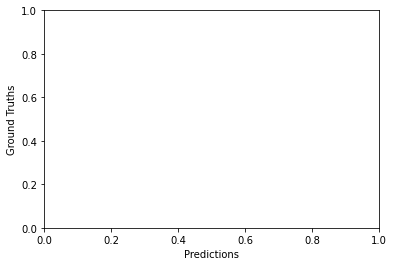

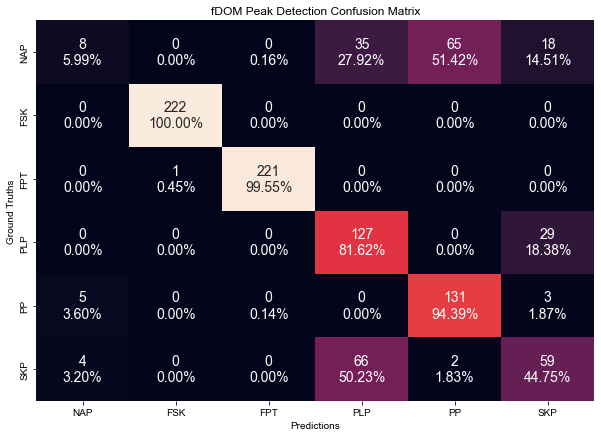

In [10]:
# save accumulated metrics
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_metrics:
    metrics = accumulated_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_metrics))

# make mean confusion matrix
mean_cfmx = np.zeros((len(classes), len(classes)))
for key in conf_matrices.keys():
    mean_cfmx += conf_matrices[key]

mean_cfmx = mean_cfmx / len(conf_matrices)

plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Confusion Matrix")

sn.set(font_scale=1.5)

group_counts = ["{0:0.0f}\n".format(value) for value in mean_cfmx.flatten()]
percentages = (mean_cfmx / mean_cfmx.sum(axis=1)[:, np.newaxis]).flatten()
group_percentages = ["{0:.2%}".format(value) for value in percentages]

box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(mean_cfmx.shape[0],mean_cfmx.shape[1])

plot = sn.heatmap(
    mean_cfmx.astype("float"),
    annot=box_labels,
    xticklabels=classes,
    yticklabels=classes,
    fmt="",
    cbar=False,
    annot_kws ={"size": 16},
)

plot.patch.set_facecolor('xkcd:white')

plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

plot.get_figure().savefig(
    "Anomaly_Detection/Deep_Learning/results/fdom/graphics/base-test-kfold.png"
)
